# Integrating scRNA-seq and scATAC-seq of PBMC-10K

## Load libraries and data

> Import required libraries

In [1]:
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
import seaborn as sns
import mudata as md
import scanpy as sc
import muon as mu
import numpy as np
import TriTan

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Load the MuData object from the .h5mu file.<br> 
The MuData object contains gene expression data and tf-idf transformed open chromatin data.

In [2]:
mdata = md.read("/scratch/t48955xm/PBMC-Multiome10k/PBMC10k_tp_mudata_hvg.h5mu")

In [3]:
mdata

MuData object with n_obs × n_vars = 11787 × 114392
  obs:	'celltype'
  var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  obsm:	'X_emd'
  2 modalities
    RNA:	11787 x 14796
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'log1p'
    ATAC:	11787 x 99596
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'

## Integrate data

######  TriTan can be run on a MuData object with a single command:

In [4]:
tritan = TriTan.TriTan()

In [5]:
tritan.fit(mdata)

/net/scratch2/t48955xm/TriTan.py:222: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/net/scratch2/t48955xm/TriTan.py:222: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


## Interpret the results

- Cell clusters inferred by TriTan are stored in the mdata.obs['tritan_cluster'] <br>
- Feature groups inferred by TriTan are stored in mdata.mod[mod].var['group'] <br>
- Joint embedding is stored in mdata.obsm['tritan_umap']

In [7]:
mdata

MuData object with n_obs × n_vars = 11787 × 114392
  obs:	'celltype', 'tritan_cluster'
  var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  obsm:	'X_emd', 'tritan_umap'
  2 modalities
    RNA:	11787 x 14796
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'group'
      uns:	'hvg', 'log1p'
    ATAC:	11787 x 99596
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'group'
      uns:	'hvg'

### Visualize the cell clusters

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


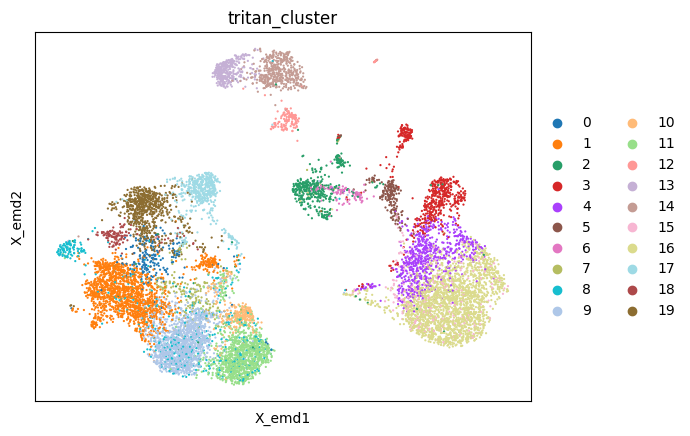

In [8]:
sc.pl.embedding(mdata, color ='tritan_cluster', basis='X_emd')

### Visualize the joint embedding

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


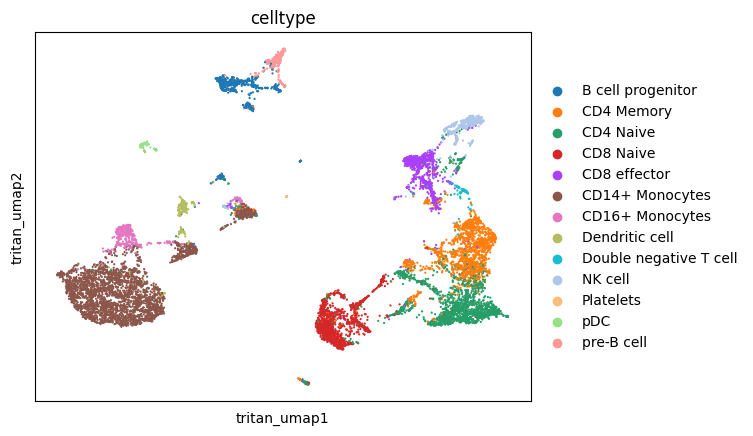

In [9]:
sc.pl.embedding(mdata, color ='celltype', basis='tritan_umap')

### Find signature feature groups for each cell cype

In [10]:
S_gene = tritan.S_gene
S_atac = tritan.S_atac

In [11]:
S_atac = normalize(S_atac, axis=0, norm='max')
S_gene = normalize(S_gene, axis=0, norm='max')

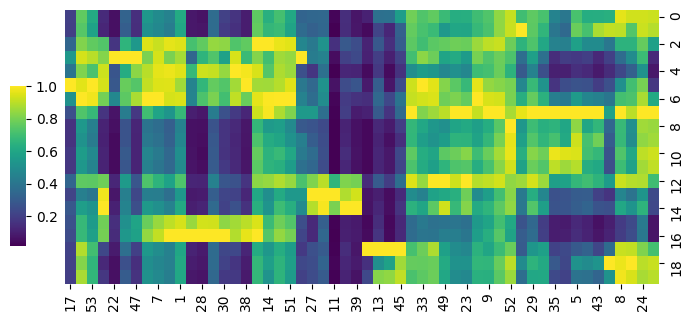

In [12]:
cg = sns.clustermap(S_gene,row_cluster=False,col_cluster=True,figsize=(8, 4), metric='correlation',cbar_pos=(0.14, .2, .02, .4),cmap='viridis')
cg.ax_row_dendrogram.set_visible(False) 
cg.ax_col_dendrogram.set_visible(False)

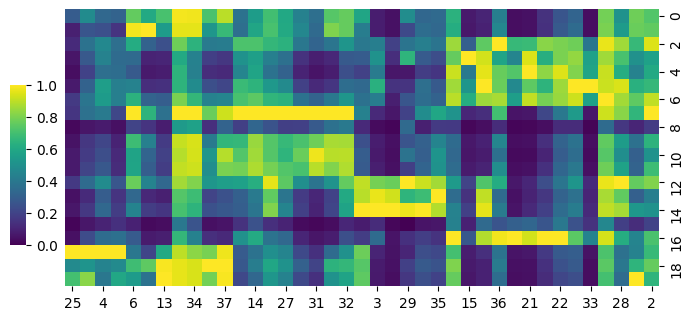

In [13]:
cg = sns.clustermap(S_atac,row_cluster=False,col_cluster=True,figsize=(8, 4), metric='correlation',cbar_pos=(0.14, .2, .02, .4),cmap='viridis')
cg.ax_row_dendrogram.set_visible(False) 
cg.ax_col_dendrogram.set_visible(False)

### Find associations of feature groups across omics

In [14]:
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)

In [17]:
I = np_pearson_cor(S_atac,S_gene)

Text(15, 1.5, 'correlation matrix')

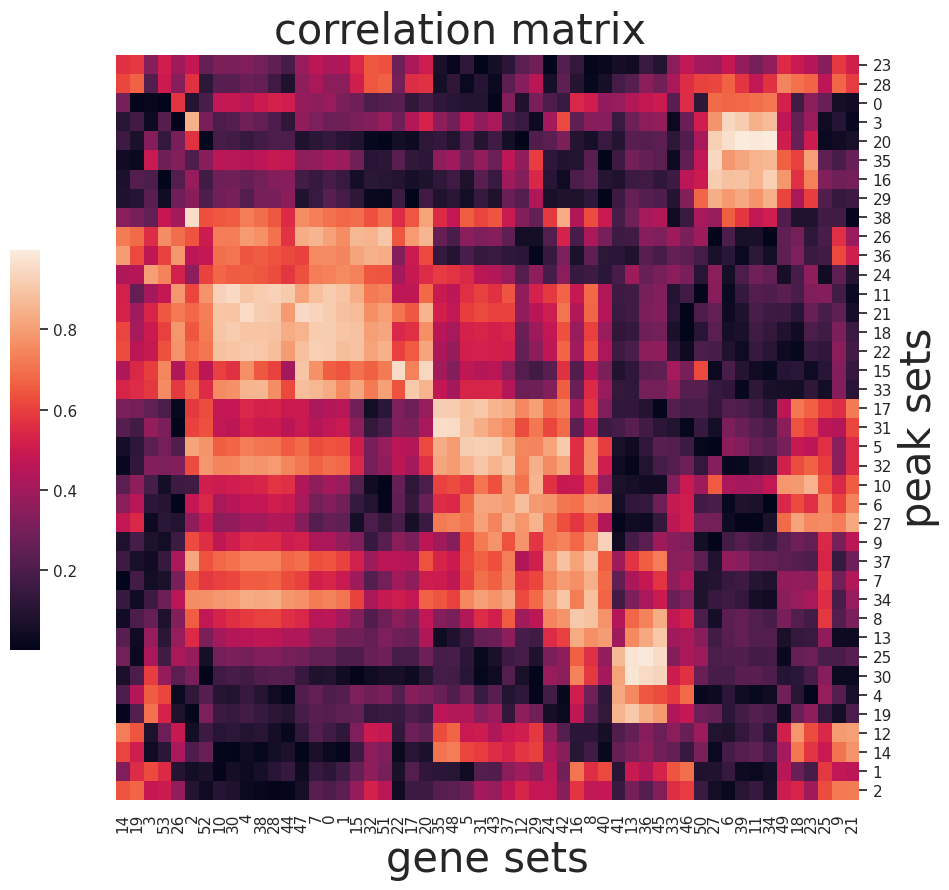

In [19]:
sns.set(font_scale=1)
g=sns.clustermap(np.abs(I),figsize=(10, 10),
    cbar_pos=(0.1, .2, .03, .4), metric='correlation',yticklabels=True,xticklabels=True)
ax = g.ax_heatmap
g.ax_row_dendrogram.set_visible(False) 
g.ax_col_dendrogram.set_visible(False)
ax.set_xlabel('gene sets', fontsize=30)
ax.set_ylabel('peak sets', fontsize=30)
plt.title('correlation matrix', fontsize=30,x=15,y=1.5)

## Saving progress

In [ ]:
mdata.write("/scratch/t48955xm/PBMC-Multiome10k/PBMC10k_tp_mudata_hvg.h5mu")